# Global Societal Endangerment Index (GSEI)

Development notebook for step 6: Weighting and Aggregation

In [1]:
import pandas as pd
import numpy as np
import categories as my_cat
from sklearn.preprocessing import StandardScaler
from scipy.stats import gmean

In [2]:
# load data
df = pd.read_csv("data/processing/normalised_all_data.csv")
countries = pd.read_csv("data/processing/selected_countries.csv")
categories = my_cat.load('4.1')
categories.pop('pca')

df

,Temp Change max 2012-2022,Disaster Affected Population 2020-2025,Disaster Damage US$T 2020-2025,Undernourishment (%),Renewable Freshwater per Capita (m3),Population below Poverty Line (%),Health Expenditure per Capita (US$),RoW Health Expenditure (%),No Education (%),Education Expenditure (US$M),...,pol_PC4,pol_PC5,pol_PC6,water_air_PC1,water_air_PC2,water_air_PC3,disease_PC1,disease_PC2,disease_PC3,disease_PC4
0,0.201103,1.118868,-1.070589,1.766991,0.435339,0.000000,-0.242164,2.913045,2.561201,0.749734,...,-0.157403,0.451415,-0.505144,1.653817,-0.551784,0.344034,0.090144,-0.350564,-0.636542,-0.235712
1,-0.252046,0.875721,-1.070589,1.440552,-0.199196,0.000000,-0.352886,2.729465,0.507129,0.047849,...,-0.231028,-0.006220,-0.390847,0.824321,-0.093015,-0.409678,1.992797,-0.404285,0.069539,-0.540231
2,0.228989,-1.639780,-1.070589,-0.416401,-0.594059,-0.016378,-1.064797,-0.511609,-0.724402,1.046331,...,0.586811,-0.234792,0.104068,-0.578045,-0.176162,0.080052,-1.054480,-0.055411,0.311029,0.261080
3,2.346589,0.026095,1.183035,-0.944423,-0.168613,-1.068933,1.266343,-0.396103,-0.737235,1.888762,...,0.219355,-0.118686,0.035244,-1.481279,0.295753,-0.300041,-2.077185,0.333092,-0.497454,-0.189044
4,-0.344419,-1.314753,-1.070589,-0.913244,2.530224,-1.068933,1.385419,-0.396103,-0.340386,-1.144288,...,0.846905,0.356944,-0.048044,-1.443530,0.430280,-0.053021,-0.416271,-0.269504,1.131575,0.000319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-0.795825,0.377215,0.906685,-0.226457,-1.153487,-0.016378,-0.780593,-0.511609,-0.466226,-0.577439,...,-0.416857,0.316650,0.536857,0.145085,-0.335460,0.634324,0.605262,-0.551248,1.068391,-0.013318
188,-0.192701,0.672441,0.568280,2.085959,1.920806,0.000000,0.134847,2.729465,2.508131,0.047849,...,-0.461834,0.256579,-0.162456,0.529793,-0.633598,0.142639,0.921834,-0.635536,-0.785883,0.997726
189,-0.149216,1.105546,1.061886,0.214688,0.671789,0.000000,-1.226685,2.729465,-0.583080,-0.905192,...,-0.322633,-0.116275,0.317120,0.477926,-0.255339,-0.603978,3.092266,4.768779,2.565955,-0.075491
190,-0.778396,1.105492,-1.070589,1.952186,-0.176332,1.933058,-0.210247,-0.511609,-0.087556,0.662586,...,-0.524287,-0.338142,-0.182993,1.585180,-0.578395,-0.472125,2.681855,1.528531,-0.796329,0.600526


## Weighting & Aggregation


In [3]:
# sub-indicator weights (different approaches)
w_total = {
    'equal': {
        "env": 1,
        "pol": 1,
        "soc": 1,
        "eco": 1,
        "threat": 1
    },
    'focus1': {
        "env": 0.3,
        "pol": 0.2,
        "soc": 0.15,
        "eco": 0.2,
        "threat": 0.15
    },
    'focus2': {
        "env": 0.12,
        "pol": 0.28,
        "soc": 0.15,
        "eco": 0.23,
        "threat": 0.22
    },
    'focus3': {
        "env": 0.20,
        "pol": 0.25,
        "soc": 0.15,
        "eco": 0.18,
        "threat": 0.22
    },
}

# weights per sub-indicator
w_cat = {
    'env': {
    "Temp Change max 2012-2022": 1.5,
    "Disaster Affected Population 2020-2025": 1.5,
    "Disaster Damage US$T 2020-2025": 1,
    "Undernourishment (%)": 1,
    "Renewable Freshwater per Capita (m3)": 1,
    "water_air_PC1": 1,
    "water_air_PC2": 1,
    "water_air_PC3": 1
    
}, 'pol': {
    "pol_PC1": 1,
    "pol_PC2": 1,
    "pol_PC3": 1,
    "pol_PC4": 1,
    "pol_PC5": 1,
    "pol_PC6": 1
    
}, 'soc': {
    "Population below Poverty Line (%)": 1.2,
    "Health Expenditure per Capita (US$)": 1,
    "RoW Health Expenditure (%)": 1,
    "No Education (%)": 1,
    "Education Expenditure (US$M)": 1,
    "Crime Rate": 1
    
}, 'eco': {
    "Government Debt (% of GDP)": 1,
    "Total Reserves (% of External Debt)": 1,
    "Gini Coefficient": 1,
    "Inflation (%)": 1,
    "Youth Unemployment (%)": 1,
    "Renewable Energy Consumption (%)": 1,
    "Secure Internet Servers": 1.2
    
}, 'threat': {
    "Future Conflict Risk": 1.5,
    "Current Conflict Intensity": 2,
    "COVID-19 Expenditure per Capita (US$)": 1.5,
    "disease_PC1": 1,
    "disease_PC2": 1,
    "disease_PC3": 1,
    "disease_PC4": 1
}}

In [4]:
# build index with weights
def aggregate_subindices(df, w, use_geo=False):
    dfw = pd.DataFrame(index=df.index)

    for cat in categories:
        sum_weights = sum(w[cat].values())

        if use_geo:
            # Ensure positivity for geometric mean
            df_shifted = df[list(w[cat].keys())] - df[list(w[cat].keys())].min() + 1
            weighted_log = (np.log(df_shifted) * list(w[cat].values())).sum(axis=1) / sum_weights
            dfw[cat] = np.exp(weighted_log)
        else:
            dfw[cat] = sum(df[ind] * (weight / sum_weights) for ind, weight in w[cat].items())

    return dfw

# Aggregate sub-indices into final index
def aggregate_index(df, w, name, use_geo=False):
    sum_weights = sum(w.values())

    if use_geo:
        df_shifted = df - df.min() + 1
        weighted_log = (np.log(df_shifted) * list(w.values())).sum(axis=1) / sum_weights
        index_values = np.exp(weighted_log)
    else:
        index_values = sum(df[cat] * (weight / sum_weights) for cat, weight in w.items())

    return pd.DataFrame({name: index_values}, index=df.index)

## Arithmetic Mean

In [5]:
sub = aggregate_subindices(df, w_cat, use_geo=False)

pd.concat([countries, sub], axis=1).sort_values(by='env', ascending=False).reset_index(drop=True)

,Country,env,pol,soc,eco,threat
0,Chad,1.307008,0.625525,0.893423,0.380091,0.998177
1,Somalia,1.279886,0.844946,0.739237,0.459137,1.139344
2,South Sudan,0.922874,0.785869,0.834585,0.211904,0.849604
3,Nigeria,0.877309,0.498629,0.884430,-0.037291,1.188753
4,Niger,0.875728,0.461275,1.452195,-0.324760,0.984635
...,...,...,...,...,...,...
187,Liechtenstein,-0.666110,-0.665775,-0.913333,-0.564227,-0.672346
188,Montenegro,-0.684247,-0.176970,0.102370,0.163125,-0.410051
189,Bhutan,-0.696209,-0.150001,-0.361025,-0.398699,-0.510074
190,Equatorial Guinea,-0.810473,0.493446,-0.255674,0.172092,0.094979


In [6]:
scaler = StandardScaler()
subn = pd.DataFrame(scaler.fit_transform(sub), columns=sub.columns)

x0 = aggregate_index(subn, w_total['equal'], 'equal', use_geo=False)
x1 = aggregate_index(subn, w_total['focus1'], 'focus1', use_geo=False)
x2 = aggregate_index(subn, w_total['focus2'], 'focus2', use_geo=False)
# focus3 is the chosen focus
x3 = aggregate_index(subn, w_total['focus3'], 'focus3', use_geo=False)

pd.concat([countries, x0, x1, x2, x3], axis=1).sort_values(by='focus3', ascending=False).reset_index(drop=True)

,Country,equal,focus1,focus2,focus3
0,Somalia,1.989613,2.161427,1.868364,2.027997
1,Yemen,1.993296,1.955626,2.025347,1.967312
2,Syrian Arab Republic,1.862281,1.895253,1.914125,1.896381
3,Chad,1.877700,2.053543,1.684496,1.874850
4,Sudan,1.779799,1.684591,1.831357,1.773021
...,...,...,...,...,...
187,New Zealand,-1.286886,-1.317847,-1.307788,-1.320240
188,Finland,-1.382494,-1.388734,-1.369869,-1.365140
189,Ireland,-1.486976,-1.630752,-1.415842,-1.504614
190,Denmark,-1.530330,-1.538372,-1.554399,-1.509382


In [7]:
final_index_arith = pd.concat([x3, subn], axis=1)
final_index_arith.columns = ['GSEI'] + list(sub.columns)

# standardize index values
scaler = StandardScaler()
final_index_arith['GSEI'] = scaler.fit_transform(final_index_arith[['GSEI']])

pd.concat([countries, final_index_arith], axis=1).sort_values(by='GSEI', ascending=False).reset_index(drop=True)

,Country,GSEI,env,pol,soc,eco,threat
0,Somalia,2.551795,3.436625,1.921386,1.476596,1.153100,1.960357
1,Yemen,2.475435,1.591218,1.831934,2.059264,2.607494,1.876573
2,Syrian Arab Republic,2.386184,1.892225,2.279360,1.458164,2.014822,1.666834
3,Chad,2.359093,3.509448,1.422429,1.784576,0.954580,1.717466
4,Sudan,2.230962,1.103811,1.876472,2.095691,1.806936,2.016084
...,...,...,...,...,...,...,...
187,New Zealand,-1.661235,-1.436945,-1.731861,-1.115898,-1.010963,-1.138760
188,Finland,-1.717733,-1.399147,-1.266508,-1.466896,-1.573319,-1.206600
189,Ireland,-1.893230,-2.511926,-1.327446,-0.896526,-1.447181,-1.251798
190,Denmark,-1.899230,-1.392188,-1.270187,-1.280194,-2.365730,-1.343351


## Geometric Mean

In [8]:
sub_geo = aggregate_subindices(df, w_cat, use_geo=True)

pd.concat([countries, sub_geo], axis=1).sort_values(by='env', ascending=False).reset_index(drop=True)

,Country,env,pol,soc,eco,threat
0,Somalia,3.890278,2.761910,3.208817,3.539968,2.949805
1,Nigeria,3.483754,2.654899,3.022132,3.028843,3.173134
2,Haiti,3.464679,2.409012,3.301082,3.861088,3.491625
3,Niger,3.400948,2.766165,3.495412,2.680732,3.001014
4,Syrian Arab Republic,3.338884,2.943329,3.119167,4.214249,3.168130
...,...,...,...,...,...,...
187,Montenegro,1.863051,2.335836,2.335393,3.464229,1.728305
188,Equatorial Guinea,1.855628,2.563179,2.239096,3.490018,2.049384
189,Finland,1.821854,2.036302,1.616370,2.604808,1.490553
190,Liechtenstein,1.818010,1.969200,1.551566,2.724008,1.516541


In [9]:
scaler = StandardScaler()
subn_geo = pd.DataFrame(scaler.fit_transform(sub_geo), columns=sub.columns)

x3_geo = aggregate_index(subn_geo, w_total['focus3'], 'focus3', use_geo=True)

final_index_geo = pd.concat([x3_geo, sub_geo], axis=1)
final_index_geo.columns = ['GSEI'] + list(sub_geo.columns)

pd.concat([countries, final_index_geo], axis=1).sort_values(by='GSEI', ascending=False).reset_index(drop=True)

,Country,GSEI,env,pol,soc,eco,threat
0,Syrian Arab Republic,4.905560,3.338884,2.943329,3.119167,4.214249,3.168130
1,Yemen,4.837560,3.232306,2.702461,3.479627,4.391503,3.248283
2,Sudan,4.727859,3.021880,2.780048,3.498906,4.040530,3.350526
3,Somalia,4.603451,3.890278,2.761910,3.208817,3.539968,2.949805
4,Afghanistan,4.558288,3.020331,2.770505,3.622004,3.928583,3.005441
...,...,...,...,...,...,...,...
187,Netherlands,1.460554,2.123909,2.067177,1.696767,2.334465,1.387068
188,Finland,1.449511,1.821854,2.036302,1.616370,2.604808,1.490553
189,Ireland,1.420069,1.656072,2.054601,1.813981,2.626848,1.467531
190,Liechtenstein,1.415460,1.818010,1.969200,1.551566,2.724008,1.516541


In [10]:
pd.set_option('display.float_format', '{:.4f}'.format)
print(final_index_arith.describe())
print(final_index_geo.describe())
pd.reset_option('display.float_format')

          GSEI      env      pol      soc      eco   threat
count 192.0000 192.0000 192.0000 192.0000 192.0000 192.0000
mean    0.0000   0.0000   0.0000   0.0000  -0.0000  -0.0000
std     1.0026   1.0026   1.0026   1.0026   1.0026   1.0026
min    -1.9119  -2.5119  -1.7319  -1.8243  -2.3657  -1.3834
25%    -0.7048  -0.6336  -0.9610  -0.7019  -0.7277  -0.7196
50%    -0.1308  -0.0664  -0.1149  -0.2551  -0.0602  -0.2963
75%     0.6386   0.5441   0.8307   0.6510   0.6726   0.5587
max     2.5518   3.5094   2.2794   2.9419   2.7780   2.6612
          GSEI      env      pol      soc      eco   threat
count 192.0000 192.0000 192.0000 192.0000 192.0000 192.0000
mean    2.8003   2.5666   2.3867   2.3015   3.2114   2.0912
std     0.7683   0.3718   0.2728   0.4827   0.4225   0.5598
min     1.2961   1.6561   1.8384   1.5516   2.2811   1.3820
25%     2.2837   2.3332   2.1531   1.9471   2.9152   1.7020
50%     2.6829   2.5606   2.3558   2.1360   3.1733   1.8936
75%     3.2757   2.7595   2.6022   2.716

In [11]:
final_index = final_index_arith.copy()

## Modifications and Extensions

Shift the index values
- subtract minimum (of all index columns) to only have positive numbers
- multiply by a chosen constant, so that the maximum index score is still below 100

Endangerment groups: Very Low, Low, Medium, High, Very High
- sum and average index values

In [12]:
all_min = np.floor(final_index.min().min() * 10) / 10.0

shifted_index = (final_index - all_min) * 18

pd.concat([countries, shifted_index], axis=1).sort_values(by='GSEI', ascending=False).reset_index(drop=True)

,Country,GSEI,env,pol,soc,eco,threat
0,Somalia,92.732307,108.659241,81.384944,73.378720,67.555800,82.086431
1,Yemen,91.357832,75.441917,79.774820,83.866747,93.734894,80.578307
2,Syrian Arab Republic,89.751313,80.860044,87.828475,73.046955,83.066789,76.803006
3,Chad,89.263665,109.970066,72.403727,78.922365,63.982447,77.714384
4,Sudan,86.957321,66.668599,80.576495,84.522439,79.324856,83.089506
...,...,...,...,...,...,...,...
187,New Zealand,16.897765,20.934997,15.626495,26.713836,28.602660,26.302315
188,Finland,15.880812,21.615362,24.002852,20.395876,18.480267,25.081205
189,Ireland,12.721855,1.585330,22.905972,30.662523,20.750748,24.267631
190,Denmark,12.613856,21.740616,23.936625,23.756511,4.216857,22.619683


array([[<Axes: title={'center': 'GSEI'}>,
        <Axes: title={'center': 'env'}>],
       [<Axes: title={'center': 'pol'}>, <Axes: title={'center': 'soc'}>],
       [<Axes: title={'center': 'eco'}>,
        <Axes: title={'center': 'threat'}>]], dtype=object)

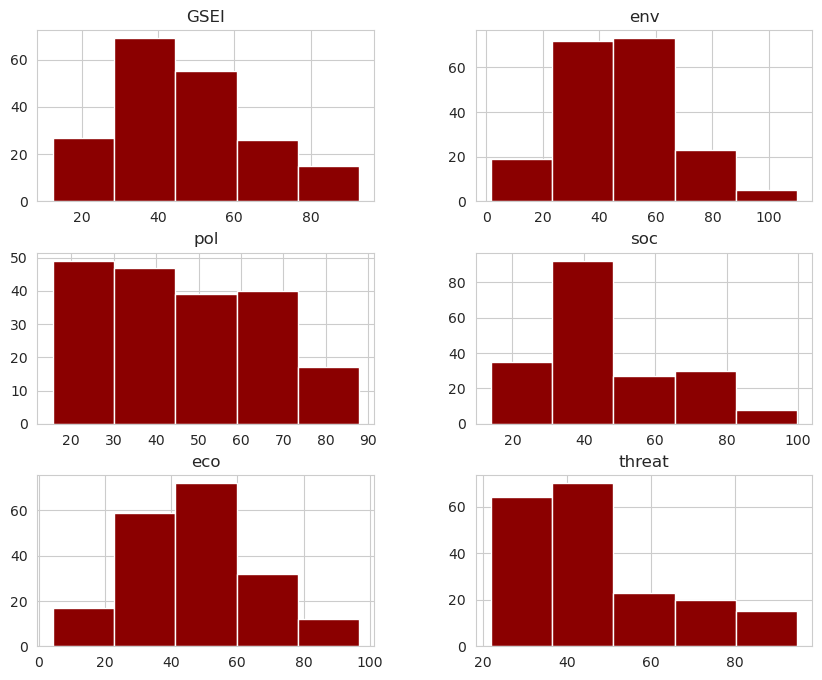

In [23]:
# histogram
shifted_index.hist(bins=5, figsize=(10, 8), color='darkred')

In [37]:
import pandas as pd
import jenkspy
import matplotlib.pyplot as plt
import seaborn as sns

def get_jenks(df, column_name, num_classes=5):
    """
    Plots histograms of a column based on Jenks natural breaks.
    """
    labels = [f"{i+1}" for i in range(num_classes)]

    # 2. Jenks Grouping
    bins_jenks = jenkspy.jenks_breaks(df[column_name], n_classes=num_classes)
    df["risk_group"] = pd.cut(
        df[column_name], bins=bins_jenks, labels=labels, include_lowest=True
    )

    # 3. Plotting
    sns.histplot(
        data=df,
        x=column_name,
        bins=15,
        hue="risk_group",
        multiple="stack",
        palette="YlOrRd",
        alpha=1,
    )
    plt.title(f"Histogram with Jenks natural breaks ({column_name})", fontsize=16)

    plt.tight_layout()

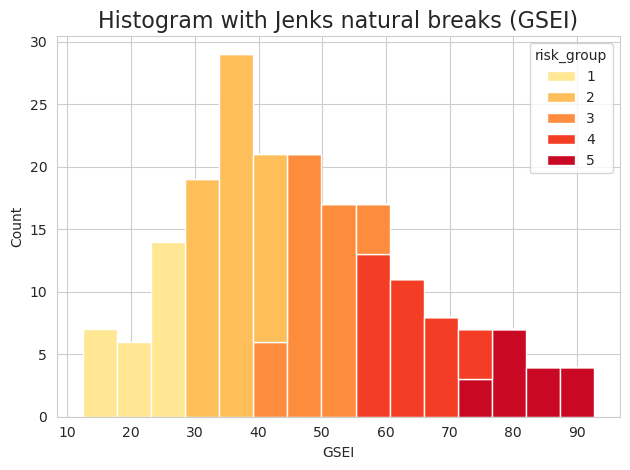

In [38]:
get_jenks(shifted_index, 'GSEI', num_classes=5)

/tmp/ipykernel_116819/315391479.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=color_palette)


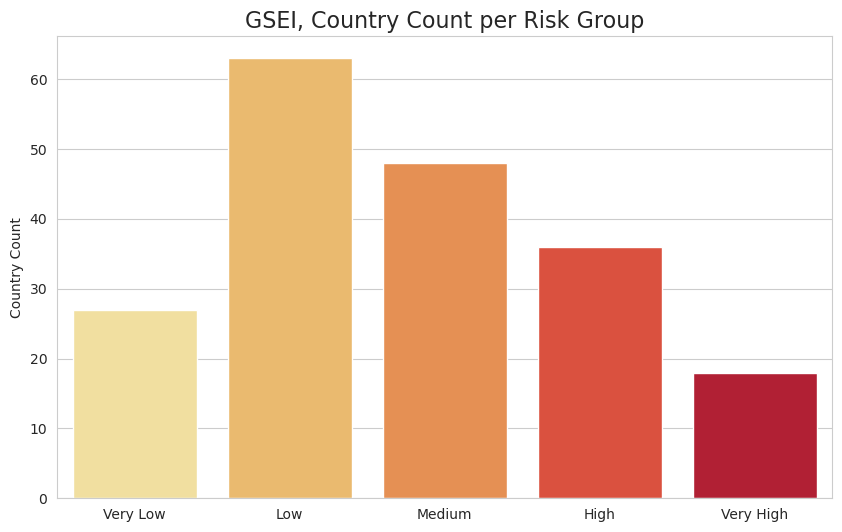

In [45]:
def plot_custom_barchart(df, column_name, category_names, color_palette):
    """
    Plots a barchart of a column with custom x-tick names and a custom color palette.
    """
    counts = df[column_name].value_counts().sort_index()
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(x=counts.index, y=counts.values, palette=color_palette)

    plt.xticks(ticks=counts.index, labels=category_names)
    plt.xlabel(None)
    plt.ylabel("Country Count")
    plt.title(f"GSEI, Country Count per Risk Group", fontsize=16)
    plt.show()
    # fig.savefig('fig.png', dpi=200, bbox_inches='tight')
    

category_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
color_palette = sns.color_palette("YlOrRd", n_colors=len(category_names)) # Sequential red palette

plot_custom_barchart(shifted_index, column_name='risk_group', category_names=category_names, color_palette=color_palette)

## Save index

In [17]:
shifted_index.head(10)

,GSEI,env,pol,soc,eco,threat,risk_group
0,85.164558,71.276117,81.962497,91.328900,72.695880,71.632567,5
1,64.944983,54.468150,55.559885,65.715542,78.176659,56.853172,4
2,35.468553,20.639642,41.567008,42.831686,50.655807,35.145633,2
3,35.425036,58.310802,24.688701,42.685657,33.288012,34.231393,2
4,37.284413,30.643011,61.736362,40.440520,23.061027,33.899487,2
5,39.487449,31.113895,38.708084,38.767245,66.060963,33.557318,2
6,44.089687,47.518639,48.865132,27.909423,43.483328,49.602725,3
7,38.426458,40.556940,28.905358,40.347362,62.138025,34.411765,2
8,18.977641,31.948011,21.451630,23.697280,24.399671,22.679965,1
9,20.976163,29.447217,25.435413,27.866923,27.949393,21.898644,1


In [18]:
save = pd.concat([countries, shifted_index], axis=1).sort_values(by='GSEI', ascending=False).reset_index(drop=True)

save.to_csv("GSEI.csv")